In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yaml
from glob import glob
import pathlib

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [3]:
log_dir = '/home/zhenyus/webcachesim/log'

In [4]:
def to_label(x):
    """
    what to put on legend
    """
    return yaml.dump(
        {k: x[k] for k in x.to_dict() if k not in {
            'cache_size', 
            'byte_hit_rate', 
            'object_hit_rate',
            'trace_file', 
            'n_warmup', 
            'n_early_stop',
            'task_id'
        } and not pd.isnull(x[k])
        })

def to_id(x):
    """
    unique identifier
    """
    return str(yaml.dump(
        {k: x[k] for k in x if k not in {
            'byte_hit_rate', 
            'object_hit_rate',
            'task_id',
        } and not pd.isnull(x[k])
        }))

    
def load_reports(log_dir):
    timestamps = glob(f'{log_dir}/*.res')
    timestamps = [pathlib.PurePosixPath(t).stem for t in timestamps]
    timestamps.sort()
    tasks = {}
    for t in timestamps:
        with open(f'{log_dir}/{t}.res') as f:
            res = yaml.load(f)
        res = {**res['res'], **res['task']}
        tasks[to_id(res)] = res
    tasks = [{'task_id': k, **v} for k, v in tasks.items()]
    df = pd.DataFrame(tasks)
#     df['task_id'] = df.apply(lambda x: to_id(x), axis='columns')
#     df = df.drop_duplicates(keep='last', subset=[
#         'task_id',
#     ])
    return df

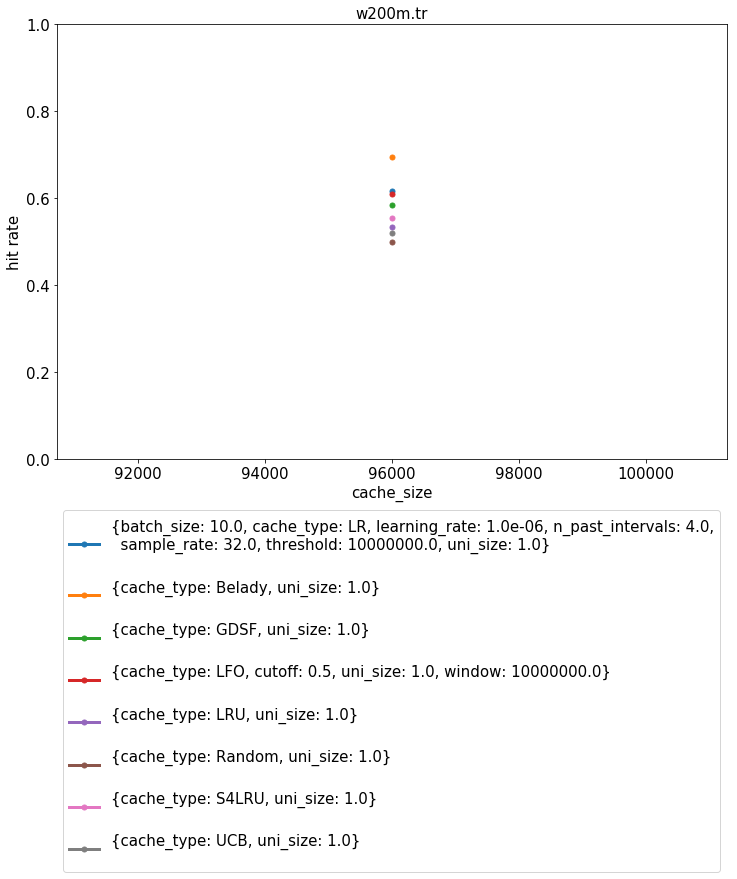

In [15]:
trace = 'w200m.tr'

df = load_reports(log_dir)
filter_idx = (
    (df.trace_file == trace)
    & (df.n_warmup == 10000000)
    & (df.uni_size == 1)
    & (df.cache_size == 96000)
#     & (
#         (df.algorithm.isin(['SLRU', 'Belady', 'Random', 'LRU', 'BeladyLR'])) 
#         | (df.algorithm.isin(['FIFOLR', 'LRULR', 'GDSFLR', 'LFULR']))
#         | ((df.algorithm == 'LR') & (df.sample_rate == 32))
#         | ((df.algorithm == 'SLRULR') & (df.sample_rate == 32))
#     )
)

df1 = df[filter_idx].copy()
df1['label'] = df1.apply(lambda x: to_label(x), axis='columns')
fig, ax = plt.subplots(figsize=(12, 8))
for k, grp in df1.groupby(['label']):
    grp = grp.sort_values(by=['cache_size'])
    ax = grp.plot(ax=ax, kind='line', x='cache_size', y='byte_hit_rate', label=k, marker='.', markersize=10)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.ylabel('hit rate')
plt.title(trace)
plt.ylim([0, 1.])
plt.show()

In [14]:
df1

,batch_size,byte_hit_rate,cache_size,cache_type,cutoff,learning_rate,n_past_intervals,n_warmup,object_hit_rate,sample_rate,task_id,threshold,trace_file,uni_size,window,label
18,NaN,0.695925,96000,Belady,NaN,NaN,NaN,10000000.0,0.695925,NaN,3,NaN,w200m.tr,1.0,NaN,"{cache_type: Belady, uni_size: 1.0}\n"
19,NaN,0.534047,96000,LRU,NaN,NaN,NaN,10000000.0,0.534047,NaN,0,NaN,w200m.tr,1.0,NaN,"{cache_type: LRU, uni_size: 1.0}\n"
20,NaN,0.609706,96000,LFO,0.5,NaN,NaN,10000000.0,0.609706,NaN,0,NaN,w200m.tr,1.0,10000000.0,"{cache_type: LFO, cutoff: 0.5, uni_size: 1.0, ..."
21,NaN,0.583516,96000,GDSF,NaN,NaN,NaN,10000000.0,0.583516,NaN,0,NaN,w200m.tr,1.0,NaN,"{cache_type: GDSF, uni_size: 1.0}\n"
22,NaN,0.499999,96000,Random,NaN,NaN,NaN,10000000.0,0.499999,NaN,0,NaN,w200m.tr,1.0,NaN,"{cache_type: Random, uni_size: 1.0}\n"
23,NaN,0.554252,96000,S4LRU,NaN,NaN,NaN,10000000.0,0.554252,NaN,0,NaN,w200m.tr,1.0,NaN,"{cache_type: S4LRU, uni_size: 1.0}\n"
24,10.0,0.616285,96000,LR,NaN,0.000001,4.0,10000000.0,0.616285,32.0,0,10000000.0,w200m.tr,1.0,NaN,"{batch_size: 10.0, cache_type: LR, learning_ra..."
25,NaN,0.520786,96000,UCB,NaN,NaN,NaN,10000000.0,0.520786,NaN,0,NaN,w200m.tr,1.0,NaN,"{cache_type: UCB, uni_size: 1.0}\n"


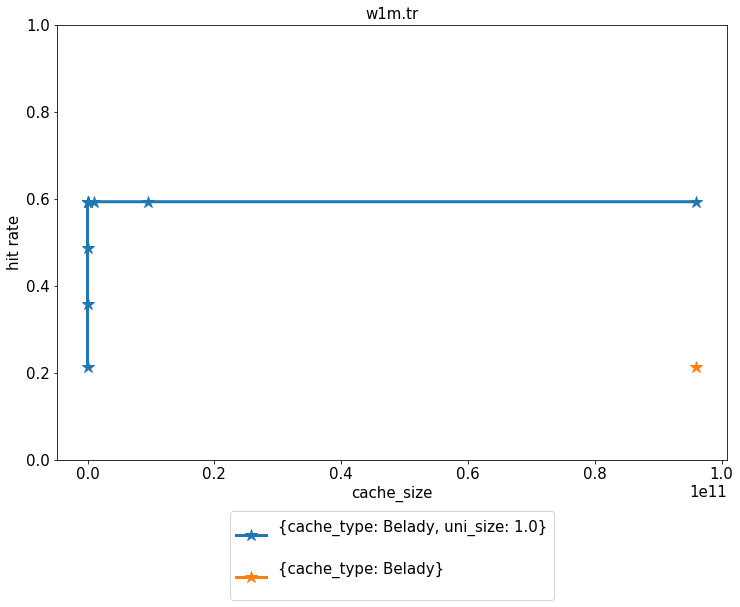

In [114]:
trace = 'w1m.tr'

df = load_reports(log_dir)
filter_idx = (
    (df.trace_file == trace) &
    (df.cache_type == 'Belady')
#     & (df.n_warmup == 100000)
#     & (df.if_uni_size == False)
#     & (df.cache_capacity <= 30000)
#     & (
#         (df.algorithm.isin(['SLRU', 'Belady', 'Random', 'LRU', 'BeladyLR'])) 
#         | (df.algorithm.isin(['FIFOLR', 'LRULR', 'GDSFLR', 'LFULR']))
#         | ((df.algorithm == 'LR') & (df.sample_rate == 32))
#         | ((df.algorithm == 'SLRULR') & (df.sample_rate == 32))
#     )
)

df1 = df[filter_idx].copy()
df1['label'] = df1.apply(lambda x: to_label(x), axis='columns')
fig, ax = plt.subplots(figsize=(12, 8))
for k, grp in df1.groupby(['label']):
    grp = grp.sort_values(by=['cache_size'])
    ax = grp.plot(ax=ax, kind='line', x='cache_size', y='byte_hit_rate', label=k, marker='*', markersize=12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.ylabel('hit rate')
plt.title(trace)
plt.ylim([0, 1.])
plt.show()

In [115]:
df1

,byte_hit_rate,cache_size,cache_type,n_warmup,object_hit_rate,task_id,trace_file,uni_size,label
3,0.593183,96000000000,Belady,NaN,0.593183,0,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
4,0.214149,96000000000,Belady,NaN,0.593148,1,w1m.tr,NaN,{cache_type: Belady}\n
6,0.593183,96000000,Belady,NaN,0.593183,4,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
7,0.593183,960000000,Belady,NaN,0.593183,5,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
8,0.593183,9600000000,Belady,NaN,0.593183,6,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
9,0.486063,9600,Belady,NaN,0.486063,0,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
10,0.593162,96000,Belady,NaN,0.593162,1,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
11,0.593183,960000,Belady,NaN,0.593183,2,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
12,0.593183,9600000,Belady,NaN,0.593183,3,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"
13,0.357149,960,Belady,NaN,0.357149,0,w1m.tr,1.0,"{cache_type: Belady, uni_size: 1.0}\n"


In [106]:
df.trace_file == trace

0    False
1    False
2     True
3     True
4     True
5     True
6     True
7     True
8     True
Name: trace_file, dtype: bool

In [45]:
df1.task_id.drop_duplicates()

5    {cache_size: 96000000000, cache_type: Belady, ...
6    {cache_size: 96000000000, cache_type: Belady, ...
7    {cache_size: 96000000000, cache_type: Belady, ...
Name: task_id, dtype: object

In [36]:
df1.task_id[6]

'{cache_size: 96000000000, cache_type: Belady, trace_file: w1m.tr}\n'

In [38]:
yaml.dump({1:2}) == yaml.dump({1:2})

True

In [42]:
to_id({2:3})

AttributeError: 'dict' object has no attribute 'to_dict'

In [51]:
df = pd.DataFrame({1:[2, 3,3,3,3], 3:[2,3,3,3,3]})

In [52]:
df

,1,3
0,2,2
1,3,3
2,3,3
3,3,3
4,3,3


In [53]:
df.drop_duplicates()

,1,3
0,2,2
1,3,3
